# Bayesian Learning Assignment 2

MSc DSAI Quentin Le Roux

<hr>
<hr>
<hr>

## Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import norm, uniform, binom
from scipy.stats import multivariate_normal
from sklearn import datasets 

<hr>

## Function declarations

**Note**: 
- *Functions are listed per exercise in alphabetical orders (exercises 4, 5, and 6 share some functions)*
- *Functions are provided with Type Hinting*

### Exercise 1 functions

In [2]:
def beta_binomial_distribution(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the beta-binomial distribution over the space of
    parameter theta, given fixed parameters alpha, beta, y, and n.
    """
    # Declares a linear space for the parameter theta
    theta_space  = np.linspace(0,1)
    # Computes and return the distribution
    distribution = theta_space**(y+alpha-1) * \
                   (1-theta_space)**(n+beta-y-1)
    return theta_space, distribution

def beta_binomial_lapproximation(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the Laplace approximation of the beta binomial
    distribution (i.e. Gaussian distribution) with parameters
    derived from the original distribution's parameters alpha,
    beta, y, and n.
    """
    theta_max = (y+alpha-1)/(n+alpha+beta-2)
    hessian   = -(y+alpha-1)/(theta_max**2) - \
                (n+beta-y-1)/((1-theta_max)**2)
    variance  = -1/hessian
    return norm(theta_max, np.sqrt(variance))

### Exercise 4 functions

*Some functions will be reused in exercise 5*.

In [3]:
def evaluate_log_post(
    params: list, 
    other_params: list, 
    data: pd.Series, 
    likelihood: str, 
    priors: list
) -> float:
    """
    Optimization function to be used to output a Laplace approximation.
    """
    # Retrieves the distribution functions (scipy implementation)
    models = {
        "gaussian":norm, 
        "uniform":uniform,
        "binomial":binom,
        
    }
    # Computes the log-priors
    log_prior = 0 
    for i, mod in enumerate(priors):
        log_prior += models[mod[0]].logpdf(params[i], *mod[1]) 
    # Guarantees positive variance in the Gaussian case
    if likelihood == "gaussian": params[-1] = np.abs(params[-1])
    # Checks for the other set of parameters and merges existing
    # parameters if need be
    if len(other_params) > 0: params = (params, other_params)
    # Computes the log-likelihood
    log_likelihood = np.sum([models[likelihood].logpdf(point, *params) 
                             for point in data])
    return - (log_likelihood + log_prior)

def evaluate_log_post_regression(
    params: list, 
    var_names: list, 
    data: pd.Series, 
    likelihood: str, 
    priors: list
) -> float:
    """
    Optimization function to be used to output a Laplace approximation
    as part of a linear regression process.
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian":norm, 
        "uniform":uniform,
        "binomial":binom
    }
    #Computes the log-priors
    log_prior = 0 
    for i, mod in enumerate(priors):
        log_prior += models[mod[0]].logpdf(params[i], *mod[1]) 
    #Evaluating expression
    target, predictors = var_names[0], var_names[1]
    # Computes the Gaussian parameters
    mu = np.ones(len(data[predictors[0]])) * params[0]
    for i in range(len(predictors)):
        mu += params[i+1] * data[predictors[i]].values
    sigma = np.abs(params[-1])
    # Computes the log-likelihood
    t = data[target].values
    N = len(t)
    log_lik = np.sum([norm.logpdf(t[i], mu[i], sigma) 
                      for i in range(N)])
    return -(log_lik + log_prior)

def laplace_solution(
    params:list,
    other_params: list,
    data: pd.Series,
    likelihood: str,
    priors:list
) -> list:
    """
    Computes a Laplace approximation of a distribution given sets of
    prior and likelihood parameters.
    """    
    # Performs an optimization over a set of parameters given an
    # evaluation function.
    minimum =  minimize(
        evaluate_log_post, params,  
        args = (other_params, data, likelihood, priors), 
        method = "BFGS"
    )
    print(minimum)
    return [minimum.x, minimum.hess_inv]

def laplace_solution_regression(
    expression: str, 
    data: pd.DataFrame, 
    likelihood: str, 
    priors: list
) -> list:
    """
    Computes a Laplace approximation for a regression given sets
    of priors and likelihood parameters
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian": norm, 
        "uniform": uniform,
        "binomial": binom
    }
    # Parses the linear regression expression
    collapsed_expression = expression.replace(" ", "")
    target, independent = collapsed_expression.split("~") 
    independent = independent.split("+")
    var_names = [target, independent]
    # Computes the random variates for each prior
    params = [models[priors[i][0]].rvs(*priors[i][1]) 
              for i in range(len(priors))]
    # Performs an optimization over a set of parameters given an
    # evaluation function.
    minimum =  minimize(
        evaluate_log_post_regression, params, 
        args = (var_names, data, likelihood, priors),
        method = "BFGS"
    )
    print(minimum, "\n")
    return [minimum.x, minimum.hess_inv]

def plot_relationship(
    x: pd.Series, y: pd.Series,
    xlabel: str, ylabel:str,
    title: str
) -> None:
    """
    Plots the 2D plot of the relationship between two variables.
    """
    plt.figure()
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show

def plot_variation(
    data: pd.DataFrame,
    depvar_name: str,
    covar_mean: list,
    covar_name: str,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str,
    posterior_samples: np.ndarray,
    posterior_means: np.ndarray,
    higher_order: bool = False,
    max_order: int = 1
):
    """
    Plots the predictive regression of a dataset. If higher order is
    True, the variable _x is exponent'd up to the maximum order fed
    into the function with the argument max_order.
    """
    # Computes the range of the plot area
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction =  posterior_means[0]
    mean_prediction += np.sum([posterior_means[i] * \
                               x_range**(i if higher_order else 1) 
                               for i in range(1, max_order+1)], axis=0)
    # Samples from a posterior distribution to obtain a predictive 
    # interval
    prediction_range = [
        posterior_samples[:,0] + np.sum([posterior_samples[:,i] * \
                                         _x**(i if higher_order else 1)
                                         for i in range(1, max_order+1)
                                        ], axis=0) 
        for _x in x_range
    ]
    prediction_range_noise = [
        norm.rvs(prediction, posterior_samples[:,-1]) 
        for prediction in prediction_range
    ]
    # Plots the base of the counterfactual graph
    n = posterior_samples.shape[0]
    plt.plot(x_range + covar_mean, mean_prediction, lw=2, color="black")
    plt.scatter(data[covar_name] + covar_mean, data[depvar_name])
    plt.title(plot_title)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)
    # Plotting the uncertainty
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean, 
                    prediction_range_noise[i], 
                    alpha = 0.05, color = 'grey')
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean,
                    prediction_range[i], 
                    alpha = 0.05, color = 'green')
    
def posterior_sampling_laplace(
    solution: list, 
    n_samples: int
) -> list:
    """
    Computes a sampling of a posterior distribution
    yielded from a Laplace approximation.
    """
    posterior_samples = multivariate_normal.rvs(
        solution[0], solution[1], size = n_samples
    )
    return posterior_samples
    
def sampling_from_posterior(
    data: pd.DataFrame, 
    mean_covariate: float, 
    depvar_name: str, 
    covar_name: str, 
    posterior_samples: multivariate_normal.rvs,
    posterior_means: list,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str
) -> None:
    """
    Samples datapoints from a posterior distribution and plots the 
    resulting distribution.
    """
    # Samples from the posterior
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction = posterior_means[0] + posterior_means[1] * x_range
    for i in range(len(posterior_samples)):
        prediction = posterior_samples[i,0] + \
                     posterior_samples[i,1] * x_range
        plt.plot(x_range + mean_covariate, prediction, 
                 lw = 0.05, color = 'grey')
    # Plots the resulting plot
    plt.scatter(data[covar_name] + mean_covariate, data[depvar_name])
    plt.plot(x_range + mean_covariate, mean_prediction, 
             lw = 2, color = 'black')
    plt.title(plot_title)
    plt.ylabel(plot_ylabel)
    plt.xlabel(plot_xlabel)
    plt.show()

def summarize(
    solution: list, 
    n_samples: int,
    names: dict={0:'a',1:'b', 2:'sigma'}, 
    plot: bool=False,
) -> tuple:
    """
    Summarizes the regression statistics obtained via a
    Laplace approximation.
    """
    # Computes posterior samples
    posterior_samples = posterior_sampling_laplace(
        solution, n_samples
    )
    #### Computes summary stats
    #    85% confidence interval
    post_quantiles = np.quantile(posterior_samples, 
                                 q = [0.075, 0.925], 
                                 axis = 0)
    #    standard deviation
    post_sd = np.std(posterior_samples, axis = 0)
    #     mean
    post_mean = np.mean(posterior_samples, axis = 0)
    # Prints the results
    summary_stats = [post_mean, post_sd, post_quantiles[0,:],
                     post_quantiles[1,:]]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
    summary_stats.rename(index=names, inplace=True)
    print(summary_stats, "\n")
    # If requested, prints the plot of the posterior data
    if plot:
        boxes = []
        for i in range(len(post_mean)):
            boxes.append(posterior_samples[:,i])
        plt.boxplot(boxes,vert=0)
        plt.yticks(range(len(post_mean)+1)[1:], names)
        plt.axvline(x=0, color = 'black', alpha = 0.1)
        plt.show()
    # Returns the posterior samples
    return post_mean, post_sd, posterior_samples

### Exercise 5 functions

*Exercise 5 reuses functions from exercise 4*.

In [4]:
def compute_WAIC(
    depvar_name: str,
    covar_name: str,
    max_order: int, 
    n_sampling: int,
    posterior_samples: list, 
    data: pd.DataFrame
) -> tuple:
    """
    Computes the WAIC metric for a set of regression model, given
    a maximum function order (linear, quadratic, cubic or fourth-order),
    posterior sampling parameters, and a dataset.
    """
    # Declares the pointwise predictive distribution and widely 
    # applicable information criterion objects to record
    lppd = []
    p_waic = []
    # Computes the log-probability for each datapoint of the 
    # dependent variable
    for i, target in enumerate(data[depvar_name]):
        # declares a lambda function computing the mean of the 
        # log pdf
        prediction = lambda s, order: posterior_samples[s, 0] + \
                     np.sum([posterior_samples[s,o] * \
                             data[f"{covar_name}{o}"][i]
                             for o in range(1, order+1)], 
                            axis = 0)
        # Computes the log-proba of the datapoint given a sampling size
        log_p = [norm.logpdf(target, loc=prediction(s, max_order), 
                             scale=posterior_samples[s, -1]) 
                 for s in range(n_sampling)]
        # Appends the results
        lppd.append(logsumexp(log_p) - np.log(len(log_p)))
        p_waic.append(np.var(log_p))
    return lppd, p_waic

def plot_boxplot_regression(
    solution: list,
    depvar_name: str,
    plot_title: str
) -> None:
    """
    Plots the confidence interval of the b (slope) parameter
    within an univariate regression between two variables. It
    allows to see if the confidence interval overlaps or falls
    away from zero.
    """
    # Samples the posterior distribution of the slope b as part
    # of an univarite regression
    boxes = posterior_sampling_laplace(solution, 5000)[:,1]
    # Plots the boxplot
    plt.figure()
    plt.boxplot(boxes,vert=0)
    plt.yticks([1], [depvar_name])
    plt.axvline(x=0, color = "black", alpha = 0.1)
    plt.title(plot_title)
    plt.show()

def plot_posterior_univariate_regression(
    solution: list, 
    x_range: np.ndarray, 
    data: pd.DataFrame, 
    center: int = 0, 
    names: list = ['x','y'], 
    n_samples: int = 5000
) -> None:
    """
    Plots the univariate regression plot of a sampling of a
    posterior distribution computed with a Laplace approximation.
    """
    # Samples from the posterior distribution obtained via
    # Laplace approximation to obtains data statistics
    post_samples = posterior_sampling_laplace(solution, n_samples)
    degree = post_samples.shape[1] - 1
    post_mean = np.mean(post_samples, axis = 0)
    mean_prediction = np.zeros(len(x_range)) + \
                      sum([post_mean[i] * x_range**i 
                           for i in range(degree)])
    # Plots the results of the sampling
    plt.plot(x_range + center, mean_prediction, 
             lw = 2, color = 'black')
    plt.title('regression result')
    plt.ylabel(names[1])
    plt.xlabel(names[0])
    list_model_samples = []
    # Samples from the posterior to get a predictive interval
    for n in range(n_samples):
        mod_sample = np.zeros(len(x_range))
        for i in range(degree):
            mod_sample += post_samples[n,i] * x_range**i
        list_model_samples.append(mod_sample)
    prediction_noise = []
    for i,mod_sample in enumerate(list_model_samples):
        prediction_noise.append(
            norm.rvs(mod_sample, post_samples[i,-1])
        )  
    # Plots the uncertainty
    for i in range(n_samples): 
        plt.scatter(x_range + center, prediction_noise[i], 
                    alpha = 0.05, color = 'grey')
        plt.scatter(x_range + center, list_model_samples[i], 
                    alpha = 0.05, color = 'green')
    plt.scatter( data[names[0]] + center, data[names[1]])
    
def summarize_WAIC_statistics(
    depvar_name: str,
    covar_name: str,
    max_order: int, 
    n_sampling: int,
    posterior_samples: list, 
    data: pd.DataFrame
) -> None:
    """
    Computes the summary of the statistic yielded with the WAIC
    method: WAIC, pWAIC, dWAIC, weight, SE, d_SE
    """
    # Declares empty variable lists for the WAIC and SE
    waic_models = []
    waic_vect_models = []
    p_waic_models = []
    se_models = []
    # For each model (with a given order), computes the WAIC and SE
    # and stores them
    for i in range(1, max_order+1):
        lppd, p_waic = compute_WAIC(depvar_name, covar_name, 
                                    i, n_sampling, 
                                    posterior_samples[i-1], data)
        waic_vect = -2*(np.array(lppd) - np.array(p_waic))
        waic = sum(waic_vect)
        p_waic = sum(p_waic)
        se = np.sqrt(len(data[depvar_name]) * np.var(waic_vect))
        # Records the results
        waic_models.append(waic)
        waic_vect_models.append(waic_vect)
        p_waic_models.append(p_waic)
        se_models.append(se)
    waic_models = np.array(waic_models)
    # Declares empty variables lists for the rest of the statistics
    d_waic = np.zeros(waic_models.shape)
    weights = np.zeros(waic_models.shape)
    d_se = np.zeros(waic_models.shape)
    # Computes the statistics
    for i in range(len(waic_models)):
        d_waic[i] = np.abs(waic_models[i] - min(waic_models))
    min_index = np.argmin(d_waic)
    for i in range(len(waic_models)):
        weights[i] = np.exp(-0.5*d_waic[i]) / \
                     (np.sum(np.exp(-0.5*d_waic)))
        if i != min_index:
            d_se[i] = np.sqrt(len(data[depvar_name])* \
                              np.var(waic_vect_models[i] - \
                                     waic_vect_models[min_index]))
        else:
            d_se[i] = np.nan
    # Prints the summary
    summary_stats = [waic_models, p_waic_models, 
                     d_waic, weights, se_models, d_se]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ["WAIC", "pWAIC", "dWAIC", 
                             "weight", "SE", "d_SE"]
    summary_stats.index = [f"model{o}" for o in range(1, max_order+1)]
    print(summary_stats)

### Exercise 6 functions

In [5]:
def summarize_WAIC_statistics_different_models(
    depvar_name: str,
    n_sampling: int,
    data: pd.DataFrame,
    expressions: dict,
    solutions: list
):
    """
    Computes the summary of the statistic yielded with the WAIC
    method: WAIC, pWAIC, dWAIC, weight, SE, d_SE for models using
    different covariates.
    """
    # Declares empty variable lists for the WAIC and SE
    waic_models = []
    waic_vect_models = []
    p_waic_models = []
    se_models = []
    for i, model in enumerate(expressions):
        lppd = []
        p_waic = []
        # Initializing the likelihood
        likelihood = 'gaussian'
        posterior_samples = posterior_sampling_laplace(
            solutions[i], n_sampling
        )
        for t, target in enumerate(data[depvar_name]):
            log_p = []
            for l in range(n_sampling):
                pred = posterior_samples[l,0] 
                for i, elem in enumerate(list(
                    expressions[model][1].values()
                )[1:-1]):
                    pred += posterior_samples[l,i]*data[elem][t]
                log_p.append(norm.logpdf(
                    target, loc=pred, scale=posterior_samples[l,-1]
                ))
            lppd.append(logsumexp(log_p) - np.log(len(log_p)))
            p_waic.append(np.var(log_p))
        waic_vect = -2*(np.array(lppd) - np.array(p_waic))
        waic = -2*(np.sum(lppd) - np.sum(p_waic))
        p_waic = np.sum(p_waic)
        se = np.sqrt(len(data[depvar_name])*np.var(waic_vect))
        # Records the results
        waic_models.append(waic)
        waic_vect_models.append(waic_vect)
        p_waic_models.append(p_waic)
        se_models.append(se)
    waic_models = np.array(waic_models)
    # Declares empty variables lists for the rest of the statistics
    d_waic = np.zeros(waic_models.shape)
    weights = np.zeros(waic_models.shape)
    d_se = np.zeros(waic_models.shape)
    # Computes the statistics
    for i in range(len(waic_models)):
        d_waic[i] = np.abs(waic_models[i] - min(waic_models))
    min_index = np.argmin(d_waic)
    for i in range(len(waic_models)):
        weights[i] = np.exp(-0.5*d_waic[i]) / (np.sum(np.exp(-0.5*d_waic)))
        if i != min_index:
            d_se[i] = np.sqrt(len(data[depvar_name])* \
                              np.var(waic_vect_models[i] - \
                                     waic_vect_models[min_index]))
        else:
            d_se[i] = np.nan
    # Prints the summary
    summary_stats = [waic_models, p_waic_models, d_waic, 
                     weights, se_models, d_se]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ["WAIC", "pWAIC", "dWAIC", 
                             "weight", "SE", "d_SE"]
    summary_stats.index = list(expressions.keys())
    print(summary_stats)

<hr>
<hr>
<hr>

## Exercise 1

### Instructions

The Beta-Binomial model seen during lesson 2 is:

$$p(y|\theta)p(\theta) \propto \theta^{y+\alpha-1}(1-\theta)^{n+\beta-y-1} \propto Beta(\theta|\alpha+y,n+\beta-y).$$

Find a Laplace approximation for this model, as seen for the Binomal model, and plot the resulting Gaussian approximation against the Beta-Binomial function.

<hr>

#### 1. Finding the Laplace approximation of the Beta-Binomial model

We recall that the Laplace method allows to approximate the shape of a given function with a Gaussian distribution. This approximation relies on the Taylor expansion of the (log-)function of interest *f*. Given *f* the function to approximate, we state the function *g* such that:

$$f(x) = \exp(\log(f(\theta)) = \exp(g(\theta))$$

Stopping at the second order, and assuming that *g* and *f* share a maximum in $\theta_0$, we can approximate *g* and thus *f* for any point $\theta$ sufficiently close to $\theta_0$ such that:

\begin{align}
g(\theta) &= g(\theta_0) + g'(\theta_0)(\theta-\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2 + o((\theta - \theta_0)^3)\\
g'(\theta_0) &= 0 \\
\end{align}

We find the following approximation:

\begin{align}
g(\theta) &\approx g(\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\\
f(\theta_0) &\approx f(\theta_0) + \exp(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2) \\
&\approx \exp\big(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\big)\quad\text{Given $f(\theta_0)$ a constant}\\
&\approx \exp\big(-\frac{1}{2}\frac{(\theta-\theta_0)^2}{-\frac{1}{g''(\theta_0)}}\big)\quad\text{We recognize a Gaussian PDF}\\
\end{align}

As such, *f* can be approximated (up to a normalization constant) by a Gaussian distribution: 

$$\mathcal{N}(\theta_0, -\frac{1}{g''(\theta_0)})$$

<u>Computing the maximum of the log-distribution:</u>

\begin{align}
g(\theta) & = \log(f(\theta)) = (y+\alpha-1)*\log(\theta) + (n+\beta-y-1)*\log(1-\theta)\\
\frac{\delta g}{\delta \theta} &= \frac{y+\alpha-1}{\theta} - \frac{n+\beta-y-1}{1-\theta}
\end{align}

As such:

\begin{align}
g'(\theta_0) &= 0\\
&\Rightarrow \frac{y+\alpha-1}{\theta_0} - \frac{n+\beta-y-1}{1-\theta_0} = 0\\
&\Rightarrow \frac{(1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1)}{\theta_0(1-\theta_0)} = 0\\
&\Rightarrow (1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1) = 0 \\
&\Rightarrow (2-n-\alpha-\beta)*\theta_0 +y+\alpha-1 = 0
\end{align}

We find:

$$\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$$

<u>Computing the second derivative of the log-distribution with respect to $\theta$:</u>

\begin{align}
\frac{\delta^2 g}{\delta \theta^2} &= -\frac{y+\alpha-1}{\theta^2} - \frac{n+\beta-y-1}{(1-\theta)^2}
\end{align}

We find:

$$g''(\theta_0) = -\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2}$$

<u>Concluding on finding the Laplace approximation of the Beta-Binomial model:</u>

The approximation will be the Gaussian:

$$\mathcal{N}\big(\frac{y+\alpha-1}{n + \alpha + \beta - 2}, -(-\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}\big)$$

with mean $\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$ and variance $\sigma^2=(\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} + \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}$

#### 2. Plotting the approximation

For plotting the resulting approximation, we first reuse the values for $\alpha$, $\beta$, $n$, and $y$ from class 5.

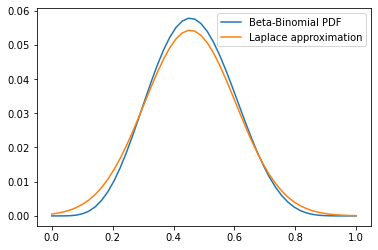

In [6]:
# Declares variables

y = 4; n = 8; alpha = 2; beta = 3

# Computes the beta-binomial PDF
theta_space, beta_binomial = beta_binomial_distribution(
    n, y, alpha, beta
)

# Computes the beta-binomial approximation
lapproximation = beta_binomial_lapproximation(n, y, alpha, beta)

# Plots the results

plt.figure()
plt.plot(
    theta_space, beta_binomial/np.sum(beta_binomial), 
    label="Beta-Binomial PDF")
plt.plot(
    theta_space,
    lapproximation.pdf(theta_space)/np.sum(
        lapproximation.pdf(theta_space)
    ),
    label="Laplace approximation")
plt.legend()
plt.show()

Let's try with another example:

\begin{align}
y&=10\\
n&=20\\
\alpha&=10\\
\beta&=20\\
\end{align}

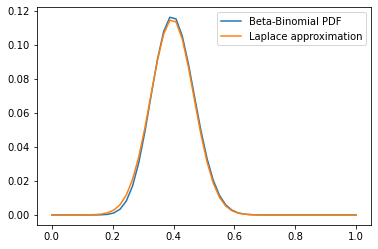

In [7]:
# Declares variables

y = 10; n = 20; alpha = 10; beta = 20

# Computes the beta-binomial PDF
theta_space, beta_binomial = beta_binomial_distribution(n, y, alpha, beta)

# Computes the beta-binomial approximation
lapproximation = beta_binomial_lapproximation(n, y, alpha, beta)

# Plots the results

plt.figure()
plt.plot(
    theta_space, beta_binomial/np.sum(beta_binomial), 
    label="Beta-Binomial PDF")
plt.plot(
    theta_space,
    lapproximation.pdf(theta_space)/np.sum(lapproximation.pdf(theta_space)),
    label="Laplace approximation")
plt.legend()
plt.show()

<hr>
<hr>
<hr>

## Exercise 2

### Instructions

Write down a model to evaluate the claim: *Animal diversity is related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

<hr>

#### 1. Problem statement

From [wikipedia](https://en.wikipedia.org/wiki/Latitude), "*latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface. Latitude is an angle (defined below) which ranges from 0° at the Equator to 90° (North or South) at the poles*." 

Common sense can lead us to assume that animal diversity is closely related to location (here, latitude). Furthermore, given prior knowledge, we may suppose that the most inhospitable areas in the world are located towards the poles, while the most hospitable would be closer to the equator (e.g. Amazonian Forest, Subsaharan Africa, etc.). Furthermore, since a biome is constituted by both fauna and flora, we can suppose that animal and plant diversity are tightly related.

As a caveat, this modeling is not without blind spots as areas such that the Sahara desert might influence the average diversity of a locale/latitude, as we are not interested in longitude as a parameter.

Finally, given these assumptions, we may hypothesize that:

- Any metric related to latitude would display some symmetric behavior with regards to the distance from the equator.
- The closer to the poles, i.e. the farther from the equator, the lower the biome diversity:
    - Animal diversity and plant diversity are related
    - Diversity decreases with increasing latitude

**Note:** Assuming any metric of animal diversity cannot be negative (at worse it would be zero), we could imagine a diversity metric as following a Poisson distribution at a given latitude.

<u>Possible example of a diversity metric per latitude given our assumptions:</u>

Represented on a graph with the x-axis the distance from the equator, and on the y-axis a metric evaluating animal diversity, we would expect a possibly linear, decreasing dataset of the following form:

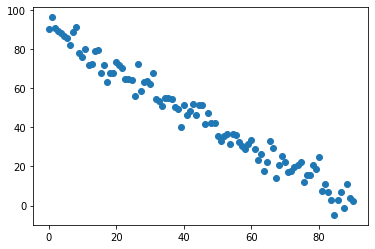

In [8]:
x = np.linspace(0, 90, num=100)
y = sorted(np.linspace(0, 90, num=100), reverse=True) + \
    np.random.normal(0, 5, 100)
plt.scatter(x, y); plt.show()

#### 2. Model definition

As such, since we are interested in a possible relationship between latitude and animal diversity, but we also want to account/control for plant diversity, we may define a preliminary model as a linear regression with `animal diversity` as the dependent variable and `latitude` and `plant diversity` as the covariates. 

We are interested in the regression function $r$ such that:

$$r \rightarrow \mathbb{E}[animal\,diversity\,\,|\,\,latitude,\,\, plant\,diversity]$$

Our resulting linear model would be as such:

\begin{align}
\text{animal diversity} &= a+b*\text{latitude} + c*\text{plant diversity}\\\\
\text{with,}\\
a&,\text{ the intercept}\\
b, c&,\text{ respective coefficients of the latitude and plant diversity covariates}
\end{align}

<hr>
<hr>
<hr>

## Exercise 3

### Instructions

Invent your own example of spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

<hr>

#### 1. Example of spurious correlation

From [Investopedia](https://www.investopedia.com/terms/s/spurious_correlation.asp), "*a spurious correlation (or spuriousness) refers to a connection between two variables that appears to be causal but is not. With spurious correlation, any observed dependencies between variables are merely due to chance or are both related to some unseen confounder.*"

An example could be the following:

> The sale of foie-gras is spuriously correlated to the sale of umbrellas in the Alpes-Maritimes, France.

If at face value it is obvious that the two variables are not causally linked, they are correlated through the underlying variable of seasonality -- the [rainiest months in the Alpes-Maritimes are October, November and December](https://en.wikipedia.org/wiki/Nice#Climate). Furthermore, foie-gras sales are [closely tied to the Christmas and New Year holidays](https://www.businesscoot.com/fr/etude/le-marche-du-foie-gras-france).

As such, we have a situation where the sale of foie-gras, being our dependent variable, should be correlated to both predictor variables: season/month of the year, and sales of umbrellas. Given a model where both covariates are included, we would expect the predictive aspect of the sales of umbrellas to decrease or disappear (since it also rains yearround, albeit in a lower amount).

<hr>
<hr>
<hr>

## Exercise 4

### Instructions

The attached data is about observations of urban foxes in human habitat. The data has 5 columns:

- *group*: Number of social group the fox belongs to
- *avgfood*: The avg amount of food available in the territory
- *groupsize*: The number of foxes in the social group
- *area*: Size of the territory
- *weight*: Body weight of the fox

Fit a regression for *weight* as a linear function of *area*, and a regression for *weight* as a linear function of *groupsize*. What can you say about these relationships? Run a multivariate model and plot counterfactual plots for both variables. What can you conclude about this analysis?

<hr>

#### 1. Data import and exploration

In [9]:
data = pd.read_csv("data.csv")
data.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


[Text(0.5, 1.0, "Distribution of urban foxes' weight")]

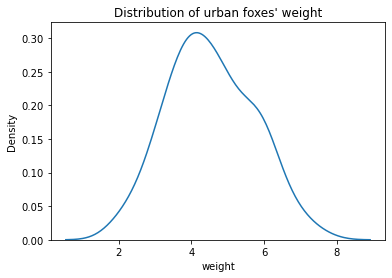

In [10]:
sns.kdeplot(data["weight"]).set(
    title="Distribution of urban foxes' weight"
)

[Text(0.5, 1.0, "Distribution of urban foxes' area")]

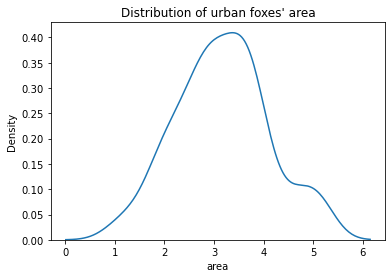

In [11]:
sns.kdeplot(data["area"]).set(
    title="Distribution of urban foxes' area"
)

[Text(0.5, 1.0, "Distribution of urban foxes' groupsize")]

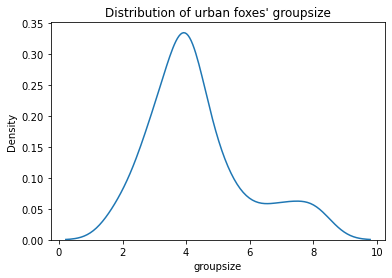

In [12]:
sns.kdeplot(data["groupsize"]).set(
    
    title="Distribution of urban foxes' groupsize")

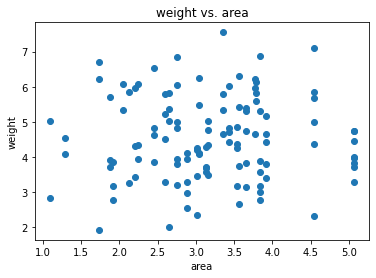

In [13]:
x, y, title= ("area", "weight", "weight vs. area")
plot_relationship(data[x], data[y], x, y, title)

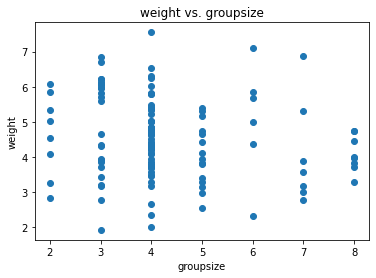

In [14]:
x, y, title= ("groupsize", "weight", "weight vs. groupsize")
plot_relationship(data[x], data[y], x, y, title)

<u>Observations:</u>

At first glance, the distribution of the dependent variable `weight` seems somewhat Gaussian. 

That cannot be said of the possible covariates `area` and `groupsize` as they both showcase a bump right-side of their distribution. 

Finally, plotting the dependent variable `weight` against either covariates yields graphs that seem to indicate either an absent or somewhat weak relationship. This will have to be verified.

#### 3. Estimating a model of `weight` sampling from prior mean and variance

To inform our choice of prior parameters for the `weight` variable in regressions with `area` and `groupsize`, we decide to estimate of model of `weight` sampling.

<u>Selecting priors:</u>

As such, we start by fitting a model for the variable `weight` only. Given the observed sample distribution, we will weakly assume that `weight` is Gaussian-distributed. `weight` is the result of infinitesimal accumulations of mass/growth during the life span of a fox, such as with the variable `height` (seen in class).

Therefore, for each fox $i$, we may assume that their `weight` is distributed as: $$\quad\text{weight}_i\sim N(\mu,\sigma^2)$$



We consider foxes to be fungible individuals, independent between each other such that:

\begin{align}
p(\text{weight}) &= p(\text{weight}_1, \text{weight}_2, \ldots, \text{weight}_N) \\
&= p(\text{weight}_1).p(\text{weight}_2)\cdots p(\text{weight}_N)
\end{align}

This corresponds to a product of Gaussian likelihoods. 

By using a Gaussian likelihood, we look into specifing a prior. As such we encode our belief with the following prior parameters:

\begin{align}
\mu_{prior} &\sim\,\,\mathcal{N}(4.5,3)\\
\sigma_{prior} &\sim\,\,\mathcal{U}(0,2)
\end{align}

**Interpretation**: Given our dataset, the average weight of an urban fox is 4.5 kilograms with a $2\sigma$-variability of c. $[0.9kg, 8.1kg]$, which seems reasonable as we likely are including the whole fox population, from pups to the largest individuals. For the variance, we don't have a clear opinion on the matter and we estimate that it can be considered as uniformly distributed on the interval $[0kg, 2kg]$.

<u>Integrating data in the model and obtaining its posterior:</u>

We specify our likelihood:

\begin{align}
p(y|\mu,\sigma^2) &= N(y|\mu,\sigma^2)\\\\
\text{with}&\,\\
y&,\,\,\text{the weight data}
\end{align}

<u>Using Laplace approximation:</u>

Because a grid method is computationally inefficient, and because we need to perform inference on $\sigma$ as well (which makes us reject using the closed form of the Gaussian), we use the Laplace approximation in order to yield a model of `weight`. As such, we rely on Laplace approximation.

In [15]:
# Declares the likelihood with the sample parameters
likelihood = "gaussian"; mu=4.53; sigma=1.18 #4.53, 1.18
parameters = [mu, sigma]

# Defines the prior mean
prior_mu_mean = 4.5; prior_mu_sigma = 3
prior_mu = ["gaussian", [prior_mu_mean, prior_mu_sigma]]

# Defines the prior sigma
sigma_inf = 0.; sigma_sup = 2.
prior_sigma = ["uniform", [sigma_inf, sigma_sup]]

# Performs the optimization
solution = laplace_solution(parameters, [], data["weight"], 
                            likelihood, [prior_mu, prior_sigma])

      fun: 186.399890424752
 hess_inv: array([[1.19675967e-02, 4.41943897e-06],
       [4.41943897e-06, 5.99152106e-03]])
      jac: array([-5.7220459e-06,  0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([4.5296157 , 1.17890797])


The variable `solution` contains both the distribution parameters of the mean and variance of the posterior distribution of `weight`. As such, we explore this new model of `weight`:

In [16]:
n_samples = 5000

posterior_samples = posterior_sampling_laplace(solution, n_samples)
print(f"`weight`'s mean parameter: {posterior_samples.mean(axis=0)}.")
print(f"`weight`'s Std.Dev parameter: {posterior_samples.std(axis=0)}.")
print("\nThe 85% quantile bounds for the `weight` mean are:\n",
      np.quantile(posterior_samples, q=[0.075, 0.925], axis=0))

`weight`'s mean parameter: [4.52941696 1.17664982].
`weight`'s Std.Dev parameter: [0.10966025 0.0774121 ].

The 85% quantile bounds for the `weight` mean are:
 [[4.37213923 1.06506151]
 [4.68840418 1.28679508]]


<u>Note:</u>

Given this model, we will use the mean and standard deviation of $\mu$ as prior parameters for performing a regression of `weight` with its covariates.

#### 3. Performing a regression with `weight` as a linear function of `area`

Now that we explored in detail the urban foxes' `weight`, we can study the relationship bwetween `weight` and `area`. As such, we are interested in the relationship: 

$$\text{weight} = a + b * \text{area}$$

The intercept $a$ expresses the `weight` of an urban fox when its `area` territory area is null (which could represent transient foxes, pups, etc.) while the slope $b$ indicates how much the mass of a fox changes with the size of its territory.

From now on, we will assume that our previous Gaussian model of `weight` (seen above) is dependent on the variable `area` through this linear relationship. The rationale would be that a larger territory would grant a fox a larger hunting area and food. In this case, we assume that the `weight` of an urban fox would be sampled from a Gaussian distribution:

$$\text{weight}_i\sim \mathcal{N}(\mu_i,\sigma^2)$$

Along with this distribution, we state that:

$$\mu_i = a + b * \text{area}_i$$

i.e., the mean $\mu_i$ varies depending on area size, and the coefficient $a$ and $b$ as well as the noise $\sigma$ are assumed to be the same across subjects.

To define our Bayesian model, we specify priors for all the parameters we want to analyze:

\begin{align}
p(a) &= \mathcal{N}(4.5, 0.11)\quad\text{Based on our previous modeling of `weight`}\\
p(b) &= \mathcal{N}(0, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

Given we have no specific belief on the impact of `area` (by looking at the previous graph, we can't even really say if there is a positive relationship with a fox's `weight`), we specify the prior of b as a Gaussian distribution with mean 0 and standard deviation 1, and the variance as being uniform.

<u>Centering the data:</u>

We center the `area` variable to avoid scale effects.

In [17]:
# Centers the data
mean_area = data["area"].mean()
centered_data = data.copy()
centered_data["area"] -= mean_area

<u>Performing the Laplace regression:</u>

In [18]:
# Declares the regression expression
expression = "weight ~ area"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 4.5; prior_a_sigma = 0.11
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 1.; prior_b_sigma = 1.
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(
    expression, centered_data, likelihood, priors
)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 184.47804115958508
 hess_inv: array([[ 5.54560290e-03,  4.48619173e-05, -7.29779711e-05],
       [ 4.48619173e-05,  1.36983729e-02,  2.23428894e-05],
       [-7.29779711e-05,  2.23428894e-05,  5.87806267e-03]])
      jac: array([0.00000000e+00, 1.90734863e-06, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 18
     njev: 23
   status: 0
  success: True
        x: array([4.51490152, 0.0383252 , 1.17884256]) 



<u>Summarizing the computed statistics:</u>

In [19]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution, n_samples)

           mean        SD      7.5%     92.5%
a      4.513130  0.073978  4.408611  4.617009
b      0.038465  0.116304 -0.129418  0.202147
sigma  1.178779  0.077514  1.068323  1.289793 



<u>Plotting the results with sampling from the posterior:</u>

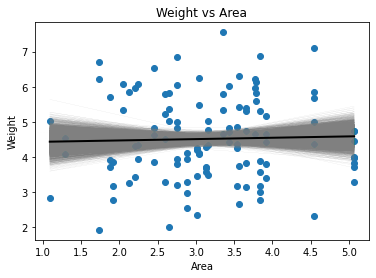

In [20]:
sampling_from_posterior(
    centered_data, mean_area, 
    "weight", "area", 
    posterior_samples, posterior_means,
    "Weight vs Area", "Area", "Weight"
)

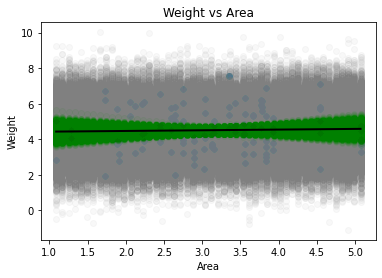

In [21]:
plot_variation(
    centered_data,
    "weight",
    mean_area,
    "area",
    'Weight vs Area',
    "Area",
    "Weight",
    posterior_samples,
    posterior_means,
    higher_order = False,
    max_order = 1
)

<u>Observations:</u>

As suspected, the impact of `area` on an urban fox's `weight` is dubious, as the result of the linear regression yields a flat or near-flat slope $b$.

As such, we may consider `area` alone to be a non-covariate of `weight`, or a (very) weak positive covariate of `weight` (given that our mean estimate of b is positive: $\approx 0.04$).

#### 4. Performing a regression with `weight` as a linear function of `groupsize`

We reproduce with `groupsize` the same workflow as with the variable `area` as we are also uncertain about the impact of `groupsize` on `area`.

> <u>Note on `groupsize` possible distribution:</u> It seems that a Poisson distribution with parameter $\lambda=4$ could work as a prior distribution in this case, given the shape of the distribution of the `groupsize` data.

<u>Centering the data:</u>

We center the `groupsize` variable to avoid scale effects.

In [22]:
# Centers the data
mean_groupsize = data["groupsize"].mean()
centered_data["groupsize"] -= mean_groupsize

<u>Performing the Laplace regression:</u>

In [23]:
# Declares the regression expression
expression = "weight ~ groupsize"

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(
    expression, centered_data, likelihood, priors
)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 183.13671221516162
 hess_inv: array([[ 6.21186294e-03, -1.35838995e-05, -7.74952359e-05],
       [-1.35838995e-05,  4.92248471e-03,  3.75684121e-05],
       [-7.74952359e-05,  3.75684121e-05,  5.81944803e-03]])
      jac: array([-1.90734863e-06, -9.53674316e-06, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 13
     njev: 19
   status: 0
  success: True
        x: array([ 4.5150938 , -0.11833607,  1.1636519 ]) 



<u>Summarizing the computed statistics:</u>

In [24]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution, n_samples)

           mean        SD      7.5%     92.5%
a      4.516037  0.078024  4.401371  4.627345
b     -0.119368  0.069341 -0.219110 -0.018644
sigma  1.164833  0.075756  1.055684  1.269835 



<u>Plotting the results with sampling from the posterior:</u>

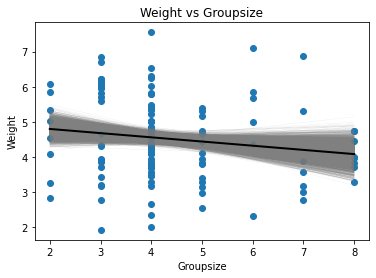

In [25]:
sampling_from_posterior(
    centered_data, mean_groupsize, 
    "weight", "groupsize", 
    posterior_samples, posterior_means,
    "Weight vs Groupsize", "Groupsize", "Weight"
)

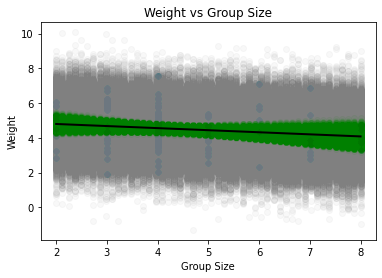

In [26]:
plot_variation(
    centered_data,
    "weight",
    mean_groupsize,
    "groupsize",
    'Weight vs Group Size',
    "Group Size",
    "Weight",
    posterior_samples,
    posterior_means,
    higher_order = True,
    max_order = 1
)

<u>Observations:</u>

The impact of `groupsize` on an urban fox's `weight` seems weakly negative (albeit in a lesser extent as the slope $b$ is stronger with `groupsize`).

#### 5. Overall comment on the two regressions

The relationship between the dependent variable `weight` and the covariates `area` and `groupsize` seems either absent (or very weakly positive) for the former and weakly negative with the latter.

#### 6. Performing a multivariate model

<u>Running the model:</u>

We reuse our priors used for the previous two regressions.

> <u>Note on computing error:</u> Sometimes a `domain error` is caused when computing plots with the `posterior_samples_2var` argument.

In [27]:
expr = 'weight ~ area + groupsize'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 4.5
prior_a_sigma = 0.11
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0.
prior_b_sigma = 1.
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_b2_mean = 0.
prior_b2_sigma = 1.
prior_b2 = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.
sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_b2, prior_sigma]

solution_regression_2var = laplace_solution_regression(
    expr, centered_data, likelihood, priors
)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 179.11521394796299
 hess_inv: array([[ 5.43944237e-03,  1.54333546e-04, -7.25251242e-05,
        -8.59032242e-05],
       [ 1.54333546e-04,  4.14433282e-02, -2.06734202e-02,
        -3.85310710e-04],
       [-7.25251242e-05, -2.06734202e-02,  1.48174021e-02,
         2.22718993e-04],
       [-8.59032242e-05, -3.85310710e-04,  2.22718993e-04,
         5.38559107e-03]])
      jac: array([-5.72204590e-06, -1.90734863e-06, -1.90734863e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 114
      nit: 17
     njev: 22
   status: 0
  success: True
        x: array([ 4.51567752,  0.58635655, -0.41480652,  1.11866289]) 



In [28]:
posterior_means, _, posterior_samples_2var = summarize(
    solution_regression_2var, n_samples,
    names={0:'a',1:'b1', 2:'b2', 3:'sigma'},
)

           mean        SD      7.5%     92.5%
a      4.516650  0.072954  4.412288  4.624146
b1     0.589329  0.202500  0.302248  0.884957
b2    -0.415475  0.121943 -0.589420 -0.243731
sigma  1.118597  0.073236  1.012849  1.225001 



<u>Plotting counterfactual plots:</u>

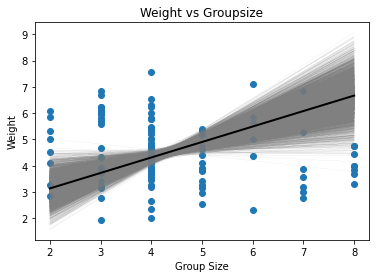

In [29]:
sampling_from_posterior(
    centered_data, mean_groupsize, 
    "weight", "groupsize", 
    posterior_samples_2var, posterior_means,
    "Weight vs Groupsize", "Group Size", "Weight"
)

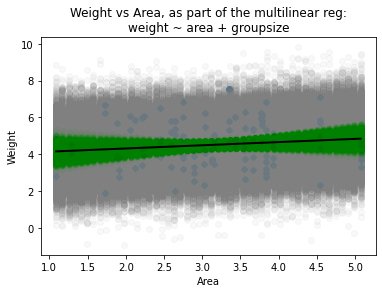

In [30]:
# sometimes causes a domain error

plot_variation(
    centered_data,
    "weight",
    mean_area,
    "area",
    f"Weight vs Area, as part of the multilinear reg:\n{expr}",
    "Area",
    "Weight",
    posterior_samples_2var,
    posterior_means,
    higher_order = False,
    max_order = 2
)

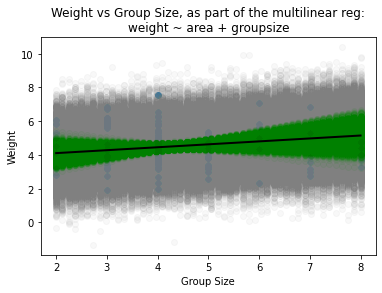

In [31]:
plot_variation(
    centered_data,
    "weight",
    mean_groupsize,
    "groupsize",
    f"Weight vs Group Size, as part of the multilinear reg:\n{expr}",
    "Group Size",
    "Weight",
    posterior_samples_2var,
    posterior_means,
    higher_order = False,
    max_order = 2
)

<u>Observations:</u>

the larger the `area`, and the larger the `groupsize`, the more uncertain the predictions. This seems tied to the lower number of datapoints as these values increases.

#### 6. Conclusion

Via the application of the multivariate Laplace approximation method, we see that using both variables `area` and `groupsize` leads to slopes `b1` and `b2` respectively increasing and decreasing in value (i.e. their effect/impact increases on the dependent variable `weight`) compared to the models where both variables are used separately. 

This indicates that there is a feedback loop between the two variables, affecting the resulting `weight` of urban foxes.

Beyond this, Looking at the plots, the closer to edge values for both `area` and `groupsize`, the higher the resulting uncertainty. As previously stated, it seems related to the thinning of the available datapoints at the most extreme ends of the dataset. 

As such, we summarize our observations:

| model | Observations |
| :--- | :---: |
| weight ~ area (univariate) | absent or very weak positive relationship | 
| weight ~ groupsize (univariate) | weak negative relationship |
| weight ~ area + groupsize (multivariate) | resp. much stronger positive and negative relationship |

<hr>
<hr>
<hr>

## Exercise 5

Consider the diabetes dataset:

In [32]:
dataset = datasets.load_diabetes(return_X_y=False)
print(dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [33]:
# Define the feature matrix
raw_data = dataset.data

# Define the target
target = dataset.target

### Instructions

Investigate the relationship between age (data[:,0]) and Average blood pressure (data[:,3]). 
By using the WAIC score seen during lesson, can you verify which hypothesis is better supported by the data?

- there is no relationship (constant)
- the relationship is linear
- the relationship is quadratic
- the relationship is cubic
- the relationship is polynomial of order 4

#### 1. Is there a  relationship between the `age` and `bp` variables?

We want to check whether or not there is a relationship between the two variables. If there is none, we might hypothesize we can eliminate searching for the other four options.

In [34]:
# Retrieves the age and bp variables as a Pandas DataFrame

data = pd.DataFrame(data = raw_data, columns = dataset.feature_names)
data = data[["age", "bp"]]
data.describe()

,age,bp
count,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.281655e-16
std,4.761905e-02,4.761905e-02
min,-1.072256e-01,-1.123996e-01
25%,-3.729927e-02,-3.665645e-02
50%,5.383060e-03,-5.670611e-03
75%,3.807591e-02,3.564384e-02
max,1.107267e-01,1.320442e-01


[Text(0.5, 1.0, 'Distribution of Ages (Diabetes dataset)')]

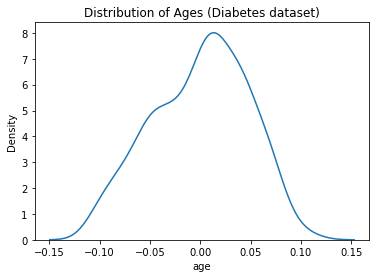

In [35]:
sns.kdeplot(data["age"]).set(
    title="Distribution of Ages (Diabetes dataset)"
)

[Text(0.5, 1.0, 'Distribution of Avg. Blood Pressures (Diabetes dataset)')]

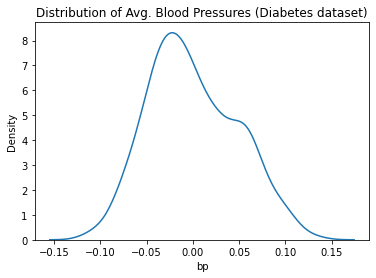

In [36]:
sns.kdeplot(data["bp"]).set(
    title="Distribution of Avg. Blood Pressures (Diabetes dataset)"
)

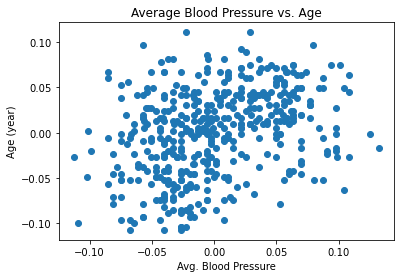

In [37]:
# Plots the relationship between the two variables

plot_relationship(
    data["bp"], data["age"], 
    xlabel="Avg. Blood Pressure", ylabel="Age (year)", 
    title="Average Blood Pressure vs. Age")

<u>Observations:</u>

- We can visually verify the note statement included in the dataset's description:

> Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

- At first glance, there seems to be a somewhat positive relationship between the variables `bp` (average blood pressure) and `age`. This is also informed by general knowledge that blood pressure is usually correlated to age, but this phenomenon will have to be assessed statistically.

<u>Studying the simple linear relationship of `age` with `bp`:</u>

Now done with a preliminary exploration of the variables `bp` and `age`, we can further study the relationship between the two variables with statistical methods. As such, we are interested in the relationship: 

\begin{align}
\text{age} &= a + b * \text{bp}\\
age &\sim \mathcal{N}(a+c*\text{bp}, \sigma)
\end{align}

The intercept $a$ expresses the `age` of a patient within the Diabetes dataset when the average blood pressure `bp` is null (here in relative terms as the dataset is centered) while the slope $b$ indicates how much the age of a patient changes with their average blood pressure.

To define our Bayesian model, we specify priors for all the parameters we want to analyze. We resort to a standard normal prior for $a$ and $b$ given the centered-ness of the dataset, the support of each variable and our lack of prior belief. 

Our lack of prior belief also informs setting the prior distribution of the parameter $\sigma$ as a uniform distribution:

\begin{align}
p(a) &= \mathcal{N}(0, 1)\\
p(b) &= \mathcal{N}(0, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

In [38]:
# Declares the regression expression
expression = "age ~ bp"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 0.; prior_a_sigma = 1.
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0.; prior_b_sigma = 1.
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(
    expression, data, likelihood, priors
)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -742.7998772739712
 hess_inv: array([[4.48580092e-06, 3.91425988e-06, 1.02126226e-08],
       [3.91425988e-06, 2.04082212e-03, 6.48909035e-06],
       [1.02126226e-08, 6.48909035e-06, 2.23860109e-06]])
      jac: array([ 7.62939453e-06,  0.00000000e+00, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 203
      nit: 20
     njev: 47
   status: 0
  success: True
        x: array([-7.42118145e-09,  3.34754547e-01,  4.48095285e-02]) 



<u>Note on optimization success:</u> It is hardly possible to obtain a successful optimization using the Scipy blackbox function `minimize` in this case, even by varying our priors.

In [39]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution, n_samples)

           mean        SD      7.5%     92.5%
a      0.000064  0.002109 -0.002928  0.003078
b      0.335487  0.044553  0.272101  0.399458
sigma  0.044796  0.001491  0.042668  0.046930 



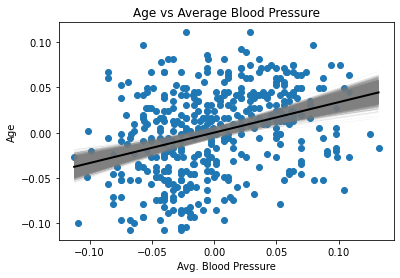

In [40]:
sampling_from_posterior(
    data, 0, 
    "age", "bp", 
    posterior_samples, posterior_means,
    "Age vs Average Blood Pressure", "Avg. Blood Pressure", "Age"
)

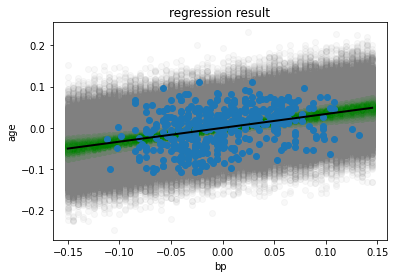

In [41]:
plot_posterior_univariate_regression(
    solution, 
    np.arange(-0.15,0.15,0.005), 
    data, 
    names = ['bp','age']
)

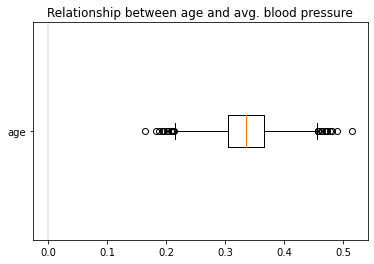

In [42]:
plot_boxplot_regression(
    solution, 
    "age", 
    "Relationship between age and avg. blood pressure"
)

<u>Observations:</u>
    
The posterior mean of the slope $b$ for `bp` is in general falling c. 0.33. Moreover the 85% posterior interval for $b$ is [0.32, 0.34], which lies well away from zero. 

As such, there is a relatively strong relationship between `age` and its covariate `bp`. We might conclude that `bp` is a reliable predictor of `age` among the patient listed in the Diabetes dataset. 

Now that we have confirmed that there is a relationship, we are interested whether or not it is linear, quadratic, cubic, or quartic.

#### 2. Application of the WAIC for hypothesis verification

Now that we have settled the observation that there is a positive relationship between the variables `age` and `bp`, we are questioning the kind of relationship it is. 

We want to test whether the relationship is:

- linear (we already did check above but we will reproduce the process below in order to compute the WAIC)
- quadratic
- cubic
- quartic

<u>Creating the dataset<u>

In [43]:
data_copy = data.copy()
data_copy['bp2'] = data_copy["bp"] ** 2
data_copy['bp3'] = data_copy["bp"] ** 3
data_copy['bp4'] = data_copy["bp"] ** 4
data_copy.rename(columns={"bp": "bp1"}, inplace=True)

data_copy.describe()

,age,bp1,bp2,bp3,bp4
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.281655e-16,2.262443e-03,3.117309e-05,1.259026e-05
std,4.761905e-02,4.761905e-02,2.736522e-03,3.198483e-04,3.004499e-05
min,-1.072256e-01,-1.123996e-01,4.557233e-09,-1.420020e-03,2.076837e-17
25%,-3.729927e-02,-3.665645e-02,3.076689e-04,-4.925509e-05,9.490351e-08
50%,5.383060e-03,-5.670611e-03,1.270483e-03,-1.823432e-07,1.614127e-06
75%,3.807591e-02,3.564384e-02,3.284857e-03,4.528490e-05,1.079028e-05
max,1.107267e-01,1.320442e-01,1.743568e-02,2.302280e-03,3.040028e-04


<u>Creating the different regression expressions:</u>

In [44]:
linear = "age ~ bp1"
quadratic = "age ~ bp1 + bp2"
cubic = "age ~ bp1 + bp2 + bp3"
quartic = "age ~ bp1 + bp2 + bp3 + bp4"

expressions = [linear, quadratic, cubic, quartic]

<u>Running the regression processes:</u>

W e are interested in the relationship:

\begin{align}
age &= a + b*bp &\text{linear}\\
&= a + b*bp + c*bp^2 &\text{quadratic}\\
&= a + b*bp + c*bp^2 + d*bp^3 &\text{cubic}\\
&= a + b*bp + c*bp^2 + d*bp^3 + e*bp^4 &\text{quartic}\\
\end{align}

To define our Bayesian model, we specify priors for all the parameters $a$, $b$, $c$, $d$, and $e$ that we want to analyze. We resort to a standard normal prior for all of them given the centered-ness of the dataset, the support of each variable and our lack of prior belief. Our lack of prior belief also inform setting the prior distribution of the parameter $\sigma$ as a unfirm distribution.

\begin{align}
p(a) &= \mathcal{N}(0, 1)\\
p(b) &= \mathcal{N}(0, 1)\\
p(c) &= \mathcal{N}(0, 1)\\
p(d) &= \mathcal{N}(0, 1)\\
p(e) &= \mathcal{N}(0, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

In [45]:
sampling_size = 5000 # sampling size to compute PDF

lppd = []
p_waic = []

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 1
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

# To avoid memory copies and overwrite, better declare
# separate object
prior_b1_mean = 0; prior_b2_mean = 0
prior_b3_mean = 0; prior_b4_mean = 0
prior_b1_sigma = 1; prior_b2_sigma = 1
prior_b3_sigma = 1; prior_b4_sigma = 1
prior_b1 = ['gaussian', [prior_b1_mean, prior_b1_sigma]]
prior_b2 = ['gaussian', [prior_b2_mean, prior_b2_sigma]]
prior_b3 = ['gaussian', [prior_b3_mean, prior_b3_sigma]]
prior_b4 = ['gaussian', [prior_b4_mean, prior_b4_sigma]]

sigma_inf = 0
sigma_sup = 2
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b1, prior_b2, prior_b3, prior_b4]

solutions = [laplace_solution_regression(
                expressions[i], data_copy, likelihood, 
                priors[:i+2] + [prior_sigma]) 
             for i in range(len(expressions))]

posterior_samples = [posterior_sampling_laplace(solutions[i], 
                                                sampling_size)
                     for i in range(len(expressions))]

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -742.7998772739738
 hess_inv: array([[ 6.42218759e-06,  8.63243552e-07,  3.23240175e-07],
       [ 8.63243552e-07,  2.58152349e-04, -2.92749795e-06],
       [ 3.23240175e-07, -2.92749795e-06,  2.35632891e-06]])
      jac: array([ 2.97546387e-04, -7.62939453e-06,  1.06811523e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 400
      nit: 24
     njev: 96
   status: 2
  success: False
        x: array([-6.10722960e-09,  3.34754520e-01,  4.48095287e-02]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -742.6203179456512
 hess_inv: array([[ 4.58914590e-06, -3.43327558e-07, -4.48726501e-06,
         5.10034147e-08],
       [-3.43327558e-07,  1.96103166e-03,  3.33932938e-07,
        -4.38808138e-09],
       [-4.48726501e-06,  3.33932938e-07,  1.39941967e-05,
         4.72132792e-06],
       [ 5.10034147e-08, -4.38808138e-09,  4.72132792e-06,
         2.38614657e-06]])
      jac: array([1.44958496e-04, 7.62939453e-06, 0.00000000e+00, 5.56945801e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 233
      nit: 21
     njev: 44
   status: 2
  success: False
        x: array([ 0.0017231 ,  0.3452307 , -0.76161811,  0.04470493]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -741.7374939720047
 hess_inv: array([[ 4.05964005e-05,  5.86094986e-04, -1.87912982e-03,
        -4.92265553e-05,  1.37641846e-06],
       [ 5.86094986e-04,  1.17607007e-02, -3.06869350e-02,
        -7.25714434e-04,  2.18969139e-05],
       [-1.87912982e-03, -3.06869350e-02,  1.53856839e-01,
         2.51494127e-03, -7.01133137e-05],
       [-4.92265553e-05, -7.25714434e-04,  2.51494127e-03,
         3.45386451e-04, -6.31287954e-06],
       [ 1.37641846e-06,  2.18969139e-05, -7.01133137e-05,
        -6.31287954e-06,  2.38366027e-06]])
      jac: array([1.98364258e-04, 7.62939453e-06, 0.00000000e+00, 7.62939453e-06,
       3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 26
     njev: 57
   status: 2
  success: False
        x: array([ 0.00172459,  0.34667707, -0.75858591, -0.26789276,  0.04469783]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -740.8187496220346
 hess_inv: array([[ 7.59750906e-06,  2.29803936e-05, -8.53692459e-04,
        -4.71558255e-05,  9.06082551e-04, -3.70117628e-07],
       [ 2.29803936e-05,  2.07511742e-03, -5.96104976e-03,
        -2.26387162e-03,  8.38839615e-03, -1.43882299e-06],
       [-8.53692459e-04, -5.96104976e-03,  2.47761274e-01,
         1.03514739e-02, -2.59883933e-01,  7.61584858e-05],
       [-4.71558255e-05, -2.26387162e-03,  1.03514739e-02,
         1.25148880e-02, -3.30017252e-02,  3.65391819e-06],
       [ 9.06082551e-04,  8.38839615e-03, -2.59883933e-01,
        -3.30017252e-02,  3.25878501e-01, -8.23674115e-05],
       [-3.70117628e-07, -1.43882299e-06,  7.61584858e-05,
         3.65391819e-06, -8.23674115e-05,  2.12838533e-06]])
      jac: array([-1.29699707e-04,  0.00000000e+00, -7.62939453e-06, -7.62939453e-06,
        0.00000000e+00,  5.34057617e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 371
      nit: 31
     njev: 5

<u>Note on optimization success:</u> It is hardly possible to obtain a successful optimization using the Scipy blackbox function `minimize` in this case, even by varying our priors.

In [46]:
models = ["linear", "quadratic", "cubic", "quartic"]
col_names = ["a", "b1", "b2", "b3", "b4", "sigma"]

for i, solution in enumerate(solutions):
    print(f"Regression results for a {models[i]} model:")
    names = dict(zip(range(i + 3), col_names[:i+2]+col_names[-1:]))
    _, _, _ = summarize(solution, n_samples, names=names); print("\n")

Regression results for a linear model:
           mean        SD      7.5%     92.5%
a      0.000035  0.002533 -0.003560  0.003714
b1     0.335007  0.015960  0.312091  0.357861
sigma  0.044825  0.001534  0.042616  0.047030 



Regression results for a quadratic model:
           mean        SD      7.5%     92.5%
a      0.001757  0.002150 -0.001359  0.004837
b1     0.344356  0.043788  0.282142  0.407601
b2    -0.761611  0.003772 -0.766996 -0.756120
sigma  0.044726  0.001553  0.042456  0.046926 



Regression results for a cubic model:
           mean        SD      7.5%     92.5%
a      0.001852  0.006368 -0.007368  0.011223
b1     0.348241  0.107836  0.193301  0.506053
b2    -0.768881  0.391558 -1.344016 -0.206353
b3    -0.268355  0.018857 -0.295880 -0.241790
sigma  0.044709  0.001536  0.042505  0.046904 



Regression results for a quartic model:
           mean        SD      7.5%     92.5%
a      0.001713  0.002745 -0.002184  0.005668
b1     0.345790  0.045462  0.281722  0.411876
b

<u>Observations:</u>

By looking at the 85% confidence intervals of the covariates `b1` to `b4` resulting from the linear, quadratic, cubic and quartic regressions, we find that all confidence intervals fall away from 0 except for the variable `b4` in the case of the quartic model. 

This seems to imply that the quartic model would offer only a weak, if not null, improvement on the other models.

As such, we would tend to hypothesize that either the linear, quadratic, or cubic models would end up being the best. The question is which one. 

To find the proper model, we use the WAIC measure.

<u>Applying the WAIC:</u>

In [47]:
# with n_sampling >> 100, this takes a while

summarize_WAIC_statistics(    
    depvar_name = "age",
    covar_name = "bp",
    max_order = 4, 
    n_sampling = sampling_size,
    posterior_samples = posterior_samples, 
    data = data_copy
)

               WAIC      pWAIC      dWAIC    weight         SE      d_SE
model1 -1485.834458   2.320994   1.207736  0.240433  25.535688  1.932895
model2 -1487.042194   2.748106   0.000000  0.439795  25.756030       NaN
model3 -1466.793099  11.971212  20.249095  0.000018  26.175268  1.220380
model4 -1486.404691   3.148074   0.637503  0.319755  25.755086  0.098591


> The WAIC should be interpreted as measure of performance when the model is applied on unseen data. And the standard error will help evaluating the uncertainty associated with the WAIC. [...] The Akaike weight helps also to intepret how these different models perform with respect to each other by giving a relative measure of reliability. The weight should be interpreted as *the probability that the model will make the best predictions on new data, conditional on the set of models considered*.
>
> *From class 8*

<u>Interpretation:</u>

In this context, it seems that the third, cubic, model is the one performing best for this particular dataset (as it shows the smallest WAIC).

As such, we want to look at the estimates for each variable and model.

In [48]:
posterior_samples = [
    posterior_sampling_laplace(solutions[i], sampling_size) 
    for i in range(4)
]

boxes = {}

boxes["b1"] = [posterior_samples[i][:,1] for i in range(4)]
boxes["b2"] = [posterior_samples[i][:,2] for i in range(1, 4)]
boxes["b3"] = [posterior_samples[i][:,3] for i in range(2, 4)]
boxes["b4"] = [posterior_samples[i][:,4] for i in range(3, 4)]

model1_boxes = [boxes["b1"][0]]
model2_boxes = [boxes["b1"][1], boxes["b2"][0]]
model3_boxes = [boxes["b1"][2], boxes["b2"][1], boxes["b3"][0]]
model4_boxes = [boxes["b1"][3], boxes["b2"][2], boxes["b3"][1], 
                boxes["b4"][0]]

We look at the impact of the b1 covariate `blood pressure` on each model:

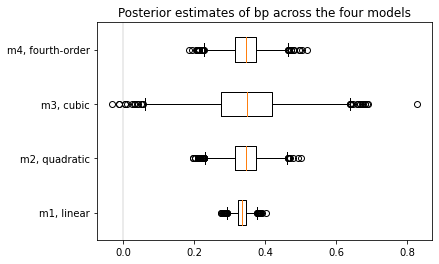

In [49]:
plt.figure()
plt.boxplot([boxes["b1"][i] for i in range(4)],vert=0)
plt.yticks([1,2,3,4], ["m1, linear", "m2, quadratic", "m3, cubic", 
                       "m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp across the four models')
plt.show()

We see that the posterior estimate for the variable `blood pressure` falls away from 0 for all models.

Now, we look at the impact of the b2 covariate `blood pressure^2` on the quadratic, cubic and quartic models:

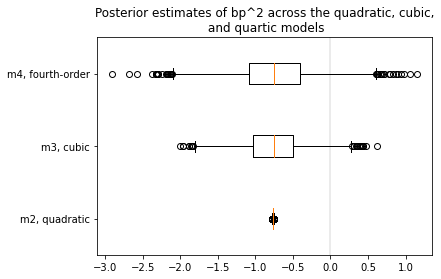

In [57]:
plt.figure()
plt.boxplot([boxes["b2"][i] for i in range(3)],vert=0)
plt.yticks([1,2,3], ["m2, quadratic", "m3, cubic", "m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp^2 across the quadratic, cubic,\n and quartic models')
plt.show()

We see that the posterior estimate for the variable `blood pressure^2` falls away from 0 for all concerned models.

Now, we look at the impact of the b3 covariate `blood pressure^3` on the cubic and quartic models:

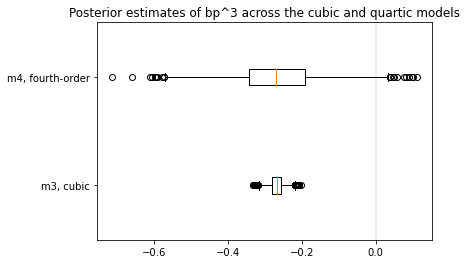

In [58]:
plt.figure()
plt.boxplot([boxes["b3"][i] for i in range(2)],vert=0)
plt.yticks([1,2], ["m3, cubic", "m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp^3 across the cubic and quartic models')
plt.show()

We see that the posterior estimate for the variable `blood pressure^3` falls away from 0 for all concerned models.

Now, we look at the impact of the b3 covariate `blood pressure^4` on the quartic model:

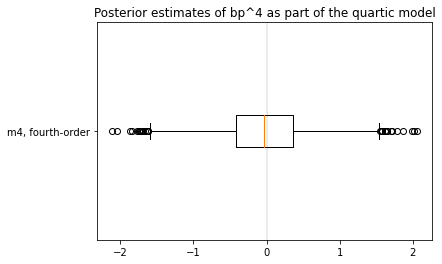

In [59]:
plt.figure()
plt.boxplot(boxes["b4"], vert=0)
plt.yticks([1], ["m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp^4 as part of the quartic model')
plt.show()

We see that the variable `blood pressure^4`'s mean and general confidence interval falls nearly straight onto 0. This implies that the variable has little to no impact on the modelization of the `age` variable.

We can also visualize the posterior estimate of the parameters for each model separately:

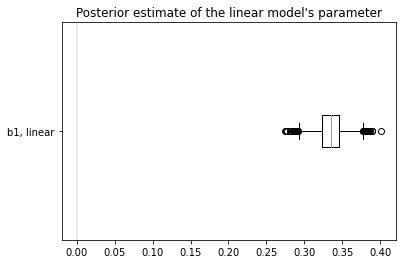

In [53]:
plt.figure()
plt.boxplot(model1_boxes, vert=0)
plt.yticks([1], ["b1, linear"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimate of the linear model's parameter")
plt.show()

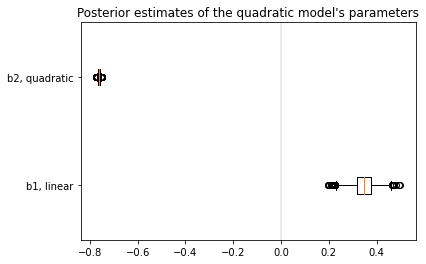

In [54]:
plt.figure()
plt.boxplot(model2_boxes, vert=0)
plt.yticks([1,2], ["b1, linear", "b2, quadratic"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimates of the quadratic model's parameters")
plt.show()

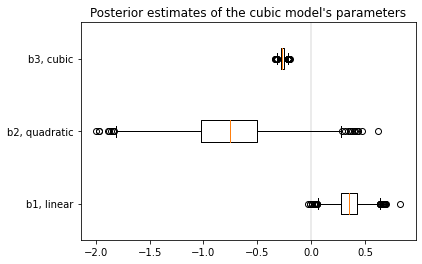

In [55]:
plt.figure()
plt.boxplot(model3_boxes, vert=0)
plt.yticks([1,2,3], ["b1, linear", "b2, quadratic", "b3, cubic"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimates of the cubic model's parameters")
plt.show()

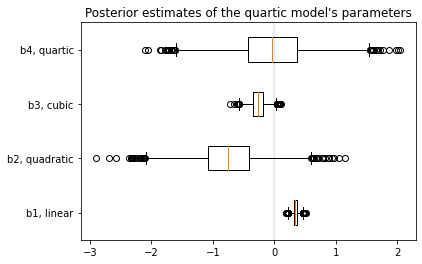

In [60]:
plt.figure()
plt.boxplot(model4_boxes, vert=0)
plt.yticks([1,2,3,4], ["b1, linear", "b2, quadratic", "b3, cubic", 
                       "b4, quartic"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimates of the quartic model's parameters")
plt.show()

<u>Interpretation:</u>

These boxplots show us how the impact of the posterior estimates for the different orders of the variable `bp`, given each model. By looking at the posterior estimates we see that each parameter besides the fourth one are relatively relevant for the modeling of the dependent variable `age` as part of the Diabetes dataset.

This importance in terms of magnitude confirms visually our previous supposition based on the WAIC estimate (which was the lowest for the cubic model).

3. **Conclusion**

Given our modeling, visual observation, and WAIC estimates for each of the models, we would favor the cubic model.

<hr>
<hr>
<hr>

## Exercise 6

### Instructions

Which model would you support between the following:

- target depends on _Age_
- target depends on _Age_ and _Sex_
- target depends on _Age_ and _Body mass index_ 
- target depends on _Age_ and _Body mass index_ and _Average blood pressure_
- target depends on _Age_ and _Sex_ and _Body mass index_ 
- target depends on _Age_ and _Sex_ and _Body mass index_ and _Average blood pressure_
- target depends on  _Body mass index_ and _Average blood pressure_

<hr>

#### 1. Data import and exploration

In [61]:
data = pd.DataFrame(data = raw_data, columns = dataset.feature_names)
data = data[["age", "sex", "bmi", "bp"]]
data["target"] = pd.Series(target)

data

,age,sex,bmi,bp,target
0,0.038076,0.050680,0.061696,0.021872,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,75.0
2,0.085299,0.050680,0.044451,-0.005671,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,206.0
4,0.005383,-0.044642,-0.036385,0.021872,135.0
...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,104.0
439,0.041708,0.050680,-0.015906,0.017282,132.0
440,-0.045472,-0.044642,0.039062,0.001215,220.0


In [75]:
data.describe()

,age,sex,bmi,bp,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,346.000000


[Text(0.5, 1.0, 'Distribution of Ages (Diabetes dataset)')]

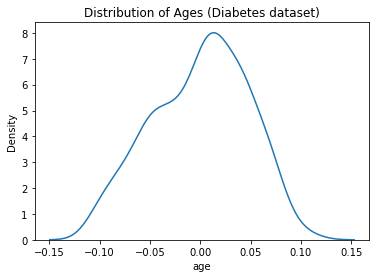

In [62]:
sns.kdeplot(data["age"]).set(
    title="Distribution of Ages (Diabetes dataset)"
)

[Text(0.5, 1.0, 'Distribution of BMI (Diabetes dataset)')]

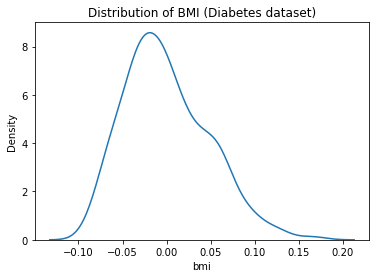

In [63]:
sns.kdeplot(data["bmi"]).set(
    title="Distribution of BMI (Diabetes dataset)"
)

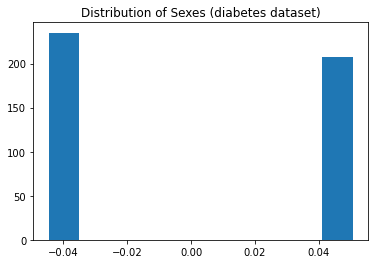

In [64]:
plt.hist(data["sex"])
plt.title(
    "Distribution of Sexes (diabetes dataset)"
)
plt.show()

In [68]:
data["sex"].unique()

array([ 0.05068012, -0.04464164])

[Text(0.5, 1.0, 'Distribution of Target (Diabetes dataset)')]

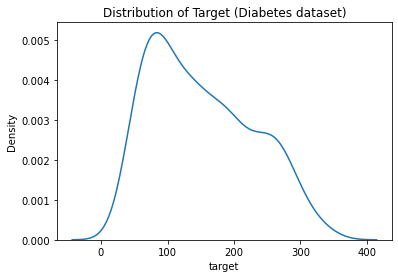

In [65]:
sns.kdeplot(data["target"]).set(
    title="Distribution of Target (Diabetes dataset)"
)

2. **Performing the regression on each model**

<u>Declaring the regression expression:</u>

In [66]:
expressions = {
    "model_1_a" : ["target ~ age", {0:"a", 1:"age", 2:"sigma"}],
    "model_2_as" : [
        "target ~ age + sex", 
        {0:"a", 1:"age", 2: "sex", 3: "sigma"}],
    "model_3_abm" : [
        "target ~ age + bp", 
        {0:"a", 1:"age", 2: "bp", 3: "sigma"}],
    "model_4_abmbp" : [
        "target ~ age + bmi + bp", 
        {0:"a", 1:"age", 2: "bmi", 3: "bp", 4: "sigma"}],
    "model_5_asbp" : [
        "target ~ age + sex + bp", 
        {0:"a", 1:"age", 2: "sex", 3: "bp", 4: "sigma"}],
    "model_6_asbmbp" : [
        "target ~ age + sex + bmi + bp", 
        {0:"a", 1:"age", 2: "sex", 3: "bmi", 4: "bp", 5: "sigma"}],
    "model_7_bmbp" : [
        "target ~ bmi + bp", 
        {0:"a", 1: "bmi", 2: "bp", 3: "sigma"}]
}

<u>Defining the prior parameters and preparing for the regression analysis:</u>

Given the centeredness of the dataset and our lack of prior belief, we declare each variable except `sex` as having a standard normal prior distribution.

> <u>Note on the choice of a prior distribution for the variable `sex`:</u>
>
> We would have chosen the binomial distribution to characterize the prior distribution of this variable (given that only two possible values are possible: 0.05, -0.04 as part of the given bernouilli process). 
>
> However, the pimplementation of the black-box optimization function (for the laplace approximation) expect the related scipy distribution function to have the logpdf() method, which the binomial distribution does not have (having the logpmf() method instead). 
>
> Given a lack of time to include that case in the optimization black-box function, we swap our distribution choice for the variable `sex` for a uniform distribution with a range of -1 to 1

In [69]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the priors with hyperparameters 

prior_a_mean = 0
prior_a_sigma = 1
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_age_mean = 0; prior_age_sigma = 1
prior_bp_mean = 0; prior_bp_sigma = 1
prior_bmi_mean = 0; prior_bmi_sigma = 1
prior_sex = ['uniform', [-1, 1]]
prior_age = ["gaussian", [prior_age_mean, prior_age_sigma]]
prior_bmi = ['gaussian', [prior_bmi_mean, prior_bmi_sigma]]
prior_bp = ['gaussian', [prior_bp_mean, prior_bp_sigma]]

sigma_inf = 0
sigma_sup = 2
prior_sigma = ['uniform', [sigma_inf, sigma_sup]]

In [70]:
priors = {
    "model_1_a" : [prior_a, prior_age, prior_sigma], 
    "model_2_as" : [prior_a, prior_age, prior_sex, prior_sigma], 
    "model_3_abm" : [prior_a, prior_age, prior_bmi, prior_sigma],
    "model_4_abmbp" : [prior_a, prior_age, prior_bmi, 
                       prior_bp, prior_sigma], 
    "model_5_asbp" : [prior_a, prior_age, prior_sex, 
                      prior_bp, prior_sigma], 
    "model_6_asbmbp" : [prior_a, prior_age, prior_sex, 
                        prior_bmi, prior_bp, prior_sigma], 
    "model_7_bmbp" : [prior_a, prior_bmi, prior_bp, prior_sigma]
}

<u>Running the regressions:</u>

In [71]:
solutions = [laplace_solution_regression(expressions[model][0], 
                                         data, likelihood, 
                                         priors[model]) 
             for model in priors.keys()]

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 373133.21480439237
 hess_inv: array([[ 6.18681031e-03,  7.95137985e-03, -1.58630238e-05],
       [ 7.95137985e-03,  8.93748739e-01, -1.68780997e-04],
       [-1.58630238e-05, -1.68780997e-04,  1.59714711e-06]])
      jac: array([-1.69753516e+03, -4.45000000e+01, -3.75007547e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 85
      nit: 6
     njev: 18
   status: 2
  success: False
        x: array([136.62734515,  29.11244043,   1.93305392]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1284072.4211786008
 hess_inv: array([[ 4.58563305e-02,  4.00085702e-02,  9.27278360e-03,
        -3.00548748e-04],
       [ 4.00085702e-02,  1.00037851e+00,  8.77209215e-05,
        -2.80494504e-04],
       [ 9.27278360e-03,  8.77209215e-05,  1.00002033e+00,
        -6.50035637e-05],
       [-3.00548748e-04, -2.80494504e-04, -6.50035637e-05,
         2.26572162e-06]])
      jac: array([-1.65382656e+04, -1.53562500e+02, -3.55781250e+01, -1.82448439e+06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 62
      nit: 2
     njev: 10
   status: 2
  success: False
        x: array([78.09134669,  0.60843515, -0.46581086,  1.40340316]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 343891.4455600238
 hess_inv: array([[ 5.84215960e-03,  3.17974986e-03,  1.43943969e-02,
        -1.41123363e-05],
       [ 3.17974986e-03,  8.81695415e-01, -1.23498120e-01,
        -1.01358940e-04],
       [ 1.43943969e-02, -1.23498120e-01,  7.12559777e-01,
        -3.23584311e-04],
       [-1.41123363e-05, -1.01358940e-04, -3.23584311e-04,
         1.93026052e-06]])
      jac: array([-1.77838672e+03, -2.02578125e+01,  7.32812500e+00, -3.24554883e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 131
      nit: 7
     njev: 23
   status: 2
  success: False
        x: array([135.06173584,  35.32824261, 148.03308048,   1.98583253]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 313851.20215182076
 hess_inv: array([[ 4.12131824e-03, -4.16951499e-04,  9.24103823e-03,
         4.28839480e-03,  2.85697021e-06],
       [-4.16951499e-04,  7.70652962e-01, -4.32936679e-02,
        -1.75307101e-01, -7.45669728e-05],
       [ 9.24103823e-03, -4.32936679e-02,  7.51173156e-01,
        -1.69934032e-01, -4.22417450e-04],
       [ 4.28839480e-03, -1.75307101e-01, -1.69934032e-01,
         7.86391033e-01, -2.70503919e-04],
       [ 2.85697021e-06, -7.45669728e-05, -4.22417450e-04,
        -2.70503919e-04,  2.20084327e-06]])
      jac: array([-1.02416016e+03,  4.41015625e+00, -7.29531250e+01, -3.65390625e+01,
       -2.89432703e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 149
      nit: 8
     njev: 22
   status: 2
  success: False
        x: array([141.62042008,  53.21308425, 122.12282189, 100.87578293,
         1.99649258]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 916966.0106104143
 hess_inv: array([[ 1.35016167e-02,  8.98710415e-03,  2.06393532e-03,
         2.11880274e-02, -5.03483615e-05],
       [ 8.98710415e-03,  1.00010055e+00,  2.31953629e-05,
         2.37744658e-04, -4.54739936e-05],
       [ 2.06393532e-03,  2.31953629e-05,  1.00000535e+00,
         5.48459947e-05, -1.04473438e-05],
       [ 2.11880274e-02,  2.37744658e-04,  5.48459947e-05,
         1.00056215e+00, -1.07146818e-04],
       [-5.03483615e-05, -4.54739936e-05, -1.04473438e-05,
        -1.07146818e-04,  2.19413011e-07]])
      jac: array([-9.71078125e+03, -1.62757812e+02, -3.74921875e+01, -3.84359375e+02,
       -1.33911704e+06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 68
      nit: 2
     njev: 9
   status: 2
  success: False
        x: array([ 1.11084333e+02,  1.06225796e+00, -8.81995445e-02,  1.53577391e+00,
        1.35914653e+00]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1421143.1066680923
 hess_inv: array([[ 3.92846375e-03,  2.05843038e-03,  4.67901708e-04,
         6.47907340e-03,  4.86338769e-03, -3.55161723e-06],
       [ 2.05843038e-03,  1.00003901e+00,  8.97765780e-06,
         1.22082310e-04,  9.18173861e-05, -5.62807591e-06],
       [ 4.67901708e-04,  8.97765780e-06,  1.00000207e+00,
         2.80986968e-05,  2.11328139e-05, -1.29257354e-06],
       [ 6.47907340e-03,  1.22082310e-04,  2.80986968e-05,
         1.00038210e+00,  2.87371805e-04, -1.76184987e-05],
       [ 4.86338769e-03,  9.18173861e-05,  2.11328139e-05,
         2.87371805e-04,  1.00021613e+00, -1.32496457e-05],
       [-3.55161723e-06, -5.62807591e-06, -1.29257354e-06,
        -1.76184987e-05, -1.32496457e-05,  3.80670446e-09]])
      jac: array([-1.47823594e+04, -2.59046875e+02, -5.96250000e+01, -8.10718750e+02,
       -6.09750000e+02, -2.61938959e+06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 85
      nit: 2
     njev: 10


/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 319952.1883844904
 hess_inv: array([[ 6.25400063e-03,  1.24048522e-02,  1.03459228e-02,
        -2.17586516e-05],
       [ 1.24048522e-02,  7.43791501e-01, -1.79696145e-01,
        -4.08930615e-04],
       [ 1.03459228e-02, -1.79696145e-01,  8.63008867e-01,
        -2.92096355e-04],
       [-2.17586516e-05, -4.08930615e-04, -2.92096355e-04,
         2.28480778e-06]])
      jac: array([-1.59750391e+03, -2.85351562e+01, -2.48554688e+01, -2.91488930e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 115
      nit: 7
     njev: 20
   status: 2
  success: False
        x: array([136.501261  , 158.86236408, 110.9165322 ,   1.99616418]) 



<u>Note on optimization success:</u> It is hardly possible to obtain a successful optimization using the Scipy blackbox function `minimize` in this case, even by varying our priors.

3. **Computing the WAIC for each model**

In [72]:
posterior_samples = [posterior_sampling_laplace(solutions[i], 
                                                sampling_size)
                     for i in range(len(expressions))]

In [73]:
for i, exp in enumerate(expressions):
    print(f"Regression results for {exp}:")
    _, _, _ = summarize(solutions[i], n_samples, 
                        names=expressions[exp][1]); print("\n")

Regression results for model_1_a:
             mean        SD        7.5%       92.5%
a      136.626887  0.077781  136.514649  136.740354
age     29.120596  0.947477   27.748988   30.487278
sigma    1.933090  0.001254    1.931243    1.934842 



Regression results for model_2_as:
            mean        SD       7.5%      92.5%
a      78.088865  0.213705  77.786825  78.397633
age     0.621517  0.995429  -0.799483   2.060878
sex    -0.467489  1.005780  -1.914951   0.972268
sigma   1.403419  0.001489   1.401265   1.405578 



Regression results for model_3_abm:
             mean        SD        7.5%       92.5%
a      135.063174  0.075732  134.954110  135.172544
age     35.329802  0.927124   34.016644   36.653296
bp     148.043472  0.845816  146.840376  149.242724
sigma    1.985837  0.001408    1.983810    1.987862 



Regression results for model_4_abmbp:
             mean        SD        7.5%       92.5%
a      141.620708  0.064487  141.527164  141.712914
age     53.220305  0.883296 

In [74]:
# This takes a long while when the sampling size is >> 100

summarize_WAIC_statistics_different_models(
    "target",
    5000,
    data,
    expressions,
    solutions
)

                        WAIC         pWAIC         dWAIC  weight  \
model_1_a       7.163207e+05   2171.623498  1.344201e+05     0.0   
model_2_as      2.562573e+06  16171.779485  1.980673e+06     0.0   
model_3_abm     6.737979e+05   2492.563350  9.189727e+04     0.0   
model_4_abmbp   5.972063e+05   2246.751641  1.530563e+04     0.0   
model_5_asbp    1.807736e+06  11543.642831  1.225835e+06     0.0   
model_6_asbmbp  2.831279e+06  29737.779686  2.249378e+06     0.0   
model_7_bmbp    5.819006e+05   2042.600874  0.000000e+00     1.0   

                           SE           d_SE  
model_1_a        42107.616746   11498.273875  
model_2_as      161148.359361  132030.475735  
model_3_abm      40280.985274    9621.519248  
model_4_abmbp    33963.744181    6124.703213  
model_5_asbp    119856.236991   88404.613571  
model_6_asbmbp  188448.370408  156561.278474  
model_7_bmbp     34173.133757            NaN  


At first glance, given the WAIC estimates, the model 7 ``target ~ bmi + blood pressure`` seems to be the best out of all the available models. The other best models would be, in order:

\begin{align}
\text{target} &\sim \text{age} + \text{bmi} + \text{bp} &\text{(model 4)}\\
&\sim \text{age} + \text{bmi} &\text{(model 3)}\\
&\sim \text{age} &\text{(model 1)}
\end{align}

Given those observations, there exists a probability that those three models (models 1, 3, and 4) could perform better than model 7. We can verify those:

In [93]:
dWAIC_m1, dSE_m1 = 1.344201e+05, 11498.273875
dWAIC_m3, dSE_m3 = 9.189727e+04, 9621.519248
dWAIC_m4, dSE_m4 = 1.530563e+04, 6124.703213

models_to_test = {
    "target~age":[dWAIC_m1, dSE_m1],
    "target~age+bmi":[dWAIC_m3, dSE_m3],
    "target~age+bmi+bp":[dWAIC_m4, dSE_m4]
}

for model in models_to_test:
    samples = np.random.normal(
        loc=models_to_test[model][0], 
        scale=models_to_test[model][1], 
        size=100000
    )
    print(f"The probability that the model `{model}` performs better",
          "than model 7: `target~bmi+bp` is:\n",
          f"{np.sum(samples<0.)/len(samples)*100}%",
          "\n")

The probability that the model `target~age` performs better than model 7: `target~bmi+bp` is:
 0.0% 

The probability that the model `target~age+bmi` performs better than model 7: `target~bmi+bp` is:
 0.0% 

The probability that the model `target~age+bmi+bp` performs better than model 7: `target~bmi+bp` is:
 0.617% 



The WAIC should be interpreted as measure of performance when the model is applied on unseen data. And the SE will help evaluating the uncertainty associated with the WAIC. 

As such, it is quite clear that in this context we benefit of using the two predictors `bmi` and `blood pressure` (model 7).

4. **Conclusion**

Within this context and given all the computed models, we would support the seventh model ``target ~ bmi + blood pressure`` that relies on computing the dependent variable *target* with the two covariates *BMI* and *Blood Pressure*.